# LangSmith & Evaluation

 ai를 이용하여 질문/답변 case 생성 -> RAG 통해 질문에 대한 답변 생성 -> 답변내용 검증

  • AI 기반 QA 데이터셋 자동 생성: LLM을 활용하여 의료
  도메인 문서에서 단순 질문, 추론 질문, 다중 문서 참조
  질문, 조건부 질문 등 다양한 유형의 질문-답변 세트를
  자동 생성

  • RAG 시스템 평가 파이프라인 구축: Chroma vectorstore와
   OpenAI embeddings를 활용한 RAG 시스템을 구축하고,
  생성된 QA 데이터셋으로 답변 품질을 체계적으로 평가

  • ***멀티 메트릭 평가 시스템***: 답변 유사도, 질문-답변
  관련성, 컨텍스트 정밀도, 충실도 등 4가지 커스텀
  메트릭을 통해 RAG 성능을 다각도로 측정

  • LangSmith 연동 및 시각화: 평가 결과를 LangSmith에
  업로드하여 추적하고, matplotlib을 통해 메트릭 점수,
  질문 유형 분포, 성**능 분석 등을 시각화

  • 종합 분석 리포트: 최고/최저 성능 케이스 분석,
  CSV/JSON 결과 저장 등을 통해 RAG 시스템의 강점과
  개선점을 파악할 수 있는 완전한 평가 프레임워크 제공

In [1]:
# Google Colab에서 실행

# ========== 1. 패키지 설치 ==========
!pip install langsmith langchain langchain-openai langchain-community chromadb tiktoken numpy scikit-learn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.7 MB/s eta 0:0

In [2]:

# ========== 2. 환경 설정 ==========
import os
import getpass
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
from datetime import datetime
from collections import defaultdict

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

from langsmith import Client
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:

# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata
# api_key=userdata.get('api_key')
# os.environ["OPENAI_API_KEY"] = api_key
# api_key2=userdata.get('api_key2')
# os.environ["LANGCHAIN_API_KEY"] = api_key2

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "RAG_EV_ex2"                 # 수업용 프로젝트명

생성된 청크 수: 8

===== 도메인 특화 테스트 데이터 생성 =====
✅ 4개의 테스트 케이스 생성 완료

질문 유형 분포:
evolution_type
simple    4
Name: count, dtype: int64

===== RAG 시스템 구축 =====
✅ RAG 시스템 구축 완료

===== RAG 시스템 평가 시작 =====


/tmp/ipython-input-3641646954.py:368: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain({"query": row['question']})


✅ 평가 데이터 생성 완료

===== 평가 메트릭 계산 =====

===== 평가 결과 =====
answer_similarity: 0.498
answer_relevancy: 0.929
context_precision: 0.857
faithfulness: 0.820

✅ LangSmith에 데이터셋 업로드 완료: medical_rag_eval_20250831_234222


/tmp/ipython-input-3641646954.py:458: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([eval_df['answer_length'], eval_df['ground_truth_length']],


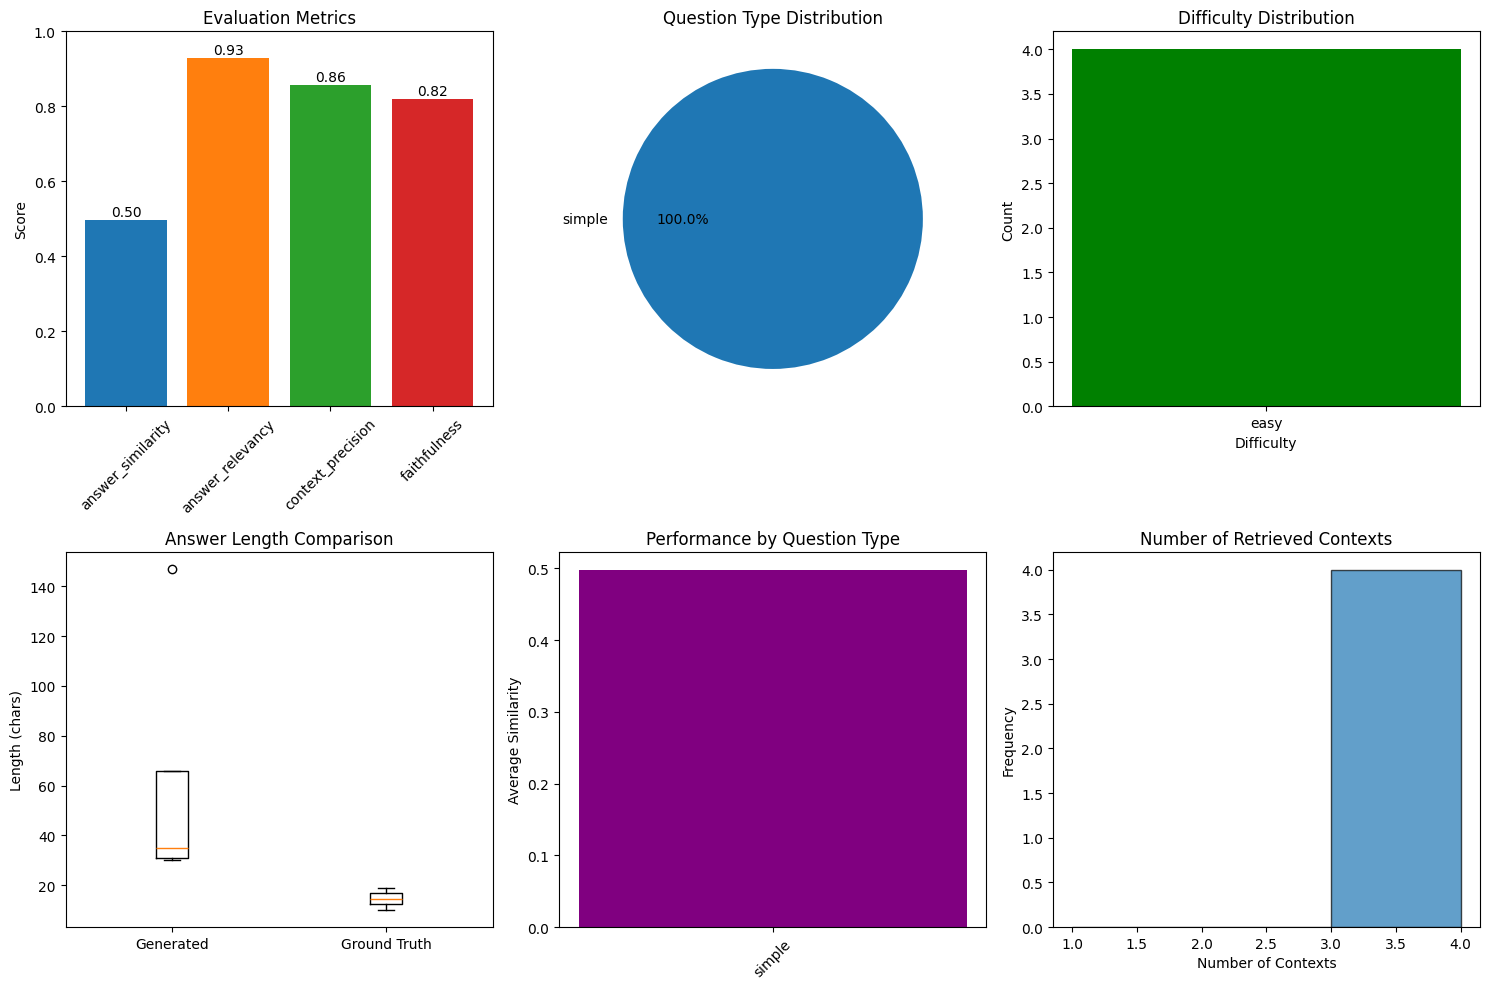


===== 상세 분석 리포트 =====
총 테스트 케이스: 4
평균 생성 답변 길이: 61.8 글자
평균 정답 길이: 14.5 글자
평균 검색 문서 수: 3.0

===== 최고 성능 케이스 =====
질문: 운동 전후 스트레칭은 어떤 역할을 합니까?
점수: 0.760

===== 최저 성능 케이스 =====
질문: 혈압 관리를 위해 어떤 방법이 제시되었나요?
점수: 0.150

✅ 평가 결과가 'rag_evaluation_results.csv'로 저장되었습니다.
✅ 메트릭이 'evaluation_metrics.json'으로 저장되었습니다.

🎉 모든 평가가 완료되었습니다!


In [ ]:


# ========== 3. 도메인 특화 문서 준비 (의료/헬스케어) ==========
domain_documents = [
    Document(
        page_content="""
        당뇨병은 인슐린의 분비량이 부족하거나 정상적인 기능이 이루어지지 않는 대사질환입니다.
        제1형 당뇨병은 인슐린을 생산하지 못해 발생하며, 주로 소아청소년기에 발병합니다.
        제2형 당뇨병은 인슐린 저항성으로 인해 발생하며, 성인에게서 주로 나타납니다.
        당뇨병의 주요 증상으로는 다뇨, 다음, 다식, 체중감소 등이 있습니다.
        혈당 관리를 위해서는 규칙적인 운동과 식이조절이 필수적입니다.
        """,
        metadata={"category": "disease", "topic": "diabetes", "doc_id": "1"}
    ),
    Document(
        page_content="""
        고혈압은 수축기 혈압이 140mmHg 이상이거나 이완기 혈압이 90mmHg 이상인 상태를 말합니다.
        고혈압은 '침묵의 살인자'로 불리며, 초기에는 특별한 증상이 없는 경우가 많습니다.
        장기간 고혈압이 지속되면 심장질환, 뇌졸중, 신장질환의 위험이 증가합니다.
        생활습관 개선과 약물치료를 통해 혈압을 관리할 수 있습니다.
        정기적인 혈압 측정과 모니터링이 중요합니다.
        """,
        metadata={"category": "disease", "topic": "hypertension", "doc_id": "2"}
    ),
    Document(
        page_content="""
        규칙적인 운동은 심혈관 건강을 개선하고 당뇨병 위험을 감소시킵니다.
        주 150분 이상의 중강도 유산소 운동이 권장됩니다.
        근력운동은 주 2-3회 실시하는 것이 좋으며, 근육량 유지에 도움이 됩니다.
        운동 전후 스트레칭은 부상 예방에 중요한 역할을 합니다.
        개인의 체력 수준에 맞는 운동 강도를 설정하는 것이 중요합니다.
        """,
        metadata={"category": "prevention", "topic": "exercise", "doc_id": "3"}
    ),
    Document(
        page_content="""
        균형잡힌 식단은 건강 유지의 기본입니다.
        하루 5가지 이상의 채소와 과일을 섭취하는 것이 권장됩니다.
        포화지방과 트랜스지방 섭취를 줄이고, 불포화지방 섭취를 늘려야 합니다.
        나트륨 섭취를 하루 2,300mg 이하로 제한하는 것이 좋습니다.
        충분한 수분 섭취는 신체 기능 유지에 필수적입니다.
        """,
        metadata={"category": "prevention", "topic": "nutrition", "doc_id": "4"}
    )
]

# ========== 4. 고급 QA 생성 클래스 ==========
class AdvancedQAGenerator:
    def __init__(self, llm):
        self.llm = llm

    def generate_domain_specific_qa(
        self,
        documents: List[Document],
        domain: str = "medical",
        qa_distribution: Dict[str, float] = None
    ) -> pd.DataFrame:
        """도메인 특화 QA 데이터셋 생성"""

        if qa_distribution is None:
            qa_distribution = {
                "simple": 0.4,
                "reasoning": 0.3,
                "multi_context": 0.2,
                "conditional": 0.1
            }

        total_questions = 15
        qa_dataset = []

        # 각 유형별 질문 수 계산
        question_counts = {
            qtype: int(total_questions * ratio)
            for qtype, ratio in qa_distribution.items()
        }

        # Simple questions
        for doc in documents[:question_counts["simple"]]:
            qa_pairs = self._generate_simple_qa(doc.page_content, domain)
            qa_dataset.extend(qa_pairs)

        # Reasoning questions
        if question_counts["reasoning"] > 0:
            qa_pairs = self._generate_reasoning_qa(
                [doc.page_content for doc in documents[:3]],
                domain,
                question_counts["reasoning"]
            )
            qa_dataset.extend(qa_pairs)

        # Multi-context questions
        if question_counts["multi_context"] > 0:
            qa_pairs = self._generate_multi_context_qa(
                documents,
                domain,
                question_counts["multi_context"]
            )
            qa_dataset.extend(qa_pairs)

        # Conditional questions
        if question_counts["conditional"] > 0:
            qa_pairs = self._generate_conditional_qa(
                documents,
                domain,
                question_counts["conditional"]
            )
            qa_dataset.extend(qa_pairs)

        return pd.DataFrame(qa_dataset)

    def _generate_simple_qa(self, text: str, domain: str) -> List[Dict]:
        """단순 사실 확인 질문"""
        prompt = f"""당신은 {domain} 분야의 전문가입니다.
다음 텍스트에서 직접 찾을 수 있는 사실 확인 질문 1개를 생성하세요.

텍스트: {text}

JSON 형식으로 출력:
{{
    "question": "질문",
    "answer": "답변",
    "difficulty": "easy"
}}"""

        response = self.llm.invoke(prompt)
        try:
            qa = json.loads(response.content)
            return [{
                "question": qa["question"],
                "ground_truth": qa["answer"],
                "contexts": [text],
                "evolution_type": "simple",
                "difficulty": qa.get("difficulty", "easy")
            }]
        except:
            return []

    def _generate_reasoning_qa(self, texts: List[str], domain: str, num: int) -> List[Dict]:
        """추론 필요 질문"""
        combined = "\n".join(texts)
        prompt = f"""당신은 {domain} 분야의 전문가입니다.
다음 정보들을 종합하여 추론이 필요한 질문 {num}개를 생성하세요.

텍스트: {combined}

JSON 배열 형식으로 출력:
[
    {{
        "question": "추론 질문",
        "answer": "논리적 답변",
        "difficulty": "medium"
    }}
]"""

        response = self.llm.invoke(prompt)
        qa_list = []
        try:
            qa_pairs = json.loads(response.content)
            for qa in qa_pairs[:num]:
                qa_list.append({
                    "question": qa["question"],
                    "ground_truth": qa["answer"],
                    "contexts": texts,
                    "evolution_type": "reasoning",
                    "difficulty": qa.get("difficulty", "medium")
                })
        except:
            pass
        return qa_list

    def _generate_multi_context_qa(self, documents: List[Document], domain: str, num: int) -> List[Dict]:
        """다중 문서 참조 질문"""
        all_texts = [doc.page_content for doc in documents]
        combined = "\n".join(all_texts)

        prompt = f"""당신은 {domain} 분야의 전문가입니다.
여러 문서의 정보를 종합해야 답할 수 있는 질문 {num}개를 생성하세요.

텍스트: {combined}

JSON 배열 형식으로 출력:
[
    {{
        "question": "종합적 질문",
        "answer": "포괄적 답변",
        "difficulty": "hard"
    }}
]"""

        response = self.llm.invoke(prompt)
        qa_list = []
        try:
            qa_pairs = json.loads(response.content)
            for qa in qa_pairs[:num]:
                qa_list.append({
                    "question": qa["question"],
                    "ground_truth": qa["answer"],
                    "contexts": all_texts,
                    "evolution_type": "multi_context",
                    "difficulty": qa.get("difficulty", "hard")
                })
        except:
            pass
        return qa_list

    def _generate_conditional_qa(self, documents: List[Document], domain: str, num: int) -> List[Dict]:
        """조건부 질문"""
        texts = [doc.page_content for doc in documents[:2]]

        prompt = f"""당신은 {domain} 분야의 전문가입니다.
특정 조건이나 상황에 따른 답변이 필요한 질문 {num}개를 생성하세요.

텍스트: {"\n".join(texts)}

JSON 배열 형식으로 출력:
[
    {{
        "question": "만약 ~라면 어떻게 되나요?",
        "answer": "조건에 따른 답변",
        "difficulty": "medium"
    }}
]"""

        response = self.llm.invoke(prompt)
        qa_list = []
        try:
            qa_pairs = json.loads(response.content)
            for qa in qa_pairs[:num]:
                qa_list.append({
                    "question": qa["question"],
                    "ground_truth": qa["answer"],
                    "contexts": texts,
                    "evolution_type": "conditional",
                    "difficulty": qa.get("difficulty", "medium")
                })
        except:
            pass
        return qa_list

# ========== 5. 커스텀 평가 메트릭 ==========
class CustomEvaluator:
    def __init__(self, embeddings_model):
        self.embeddings = embeddings_model

    def calculate_answer_similarity(self, answer: str, ground_truth: str) -> float:
        """답변 유사도 계산"""
        from difflib import SequenceMatcher
        return SequenceMatcher(None, answer.lower(), ground_truth.lower()).ratio()

    def calculate_answer_relevancy(self, question: str, answer: str) -> float:
        """질문-답변 관련성 계산"""
        q_emb = self.embeddings.embed_query(question)
        a_emb = self.embeddings.embed_query(answer)
        similarity = cosine_similarity([q_emb], [a_emb])[0][0]
        return similarity

    def calculate_context_precision(self, question: str, contexts: List[str]) -> float:
        """컨텍스트 정확도 계산"""
        if not contexts:
            return 0.0

        q_emb = self.embeddings.embed_query(question)
        context_scores = []

        for context in contexts:
            c_emb = self.embeddings.embed_query(context)
            score = cosine_similarity([q_emb], [c_emb])[0][0]
            context_scores.append(score)

        return np.mean(context_scores)

    def calculate_faithfulness(self, answer: str, contexts: List[str]) -> float:
        """답변이 컨텍스트에 충실한지 평가"""
        if not contexts:
            return 0.0

        answer_words = set(answer.lower().split())
        context_words = set(" ".join(contexts).lower().split())

        if not answer_words:
            return 0.0

        overlap = len(answer_words & context_words) / len(answer_words)
        return min(overlap * 1.5, 1.0)  # 스케일 조정

    def evaluate_all(self, eval_df: pd.DataFrame) -> Dict[str, float]:
        """모든 메트릭 계산"""
        metrics = defaultdict(list)

        for _, row in eval_df.iterrows():
            metrics['answer_similarity'].append(
                self.calculate_answer_similarity(row['answer'], row['ground_truth'])
            )
            metrics['answer_relevancy'].append(
                self.calculate_answer_relevancy(row['question'], row['answer'])
            )
            metrics['context_precision'].append(
                self.calculate_context_precision(row['question'], row['contexts'])
            )
            metrics['faithfulness'].append(
                self.calculate_faithfulness(row['answer'], row['contexts'])
            )

        # 평균 계산
        return {
            metric: np.mean(scores)
            for metric, scores in metrics.items()
        }

# ========== 6. 메인 실행 ==========
# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=40,
    separators=["\n\n", "\n", ".", ","]
)

chunks = text_splitter.split_documents(domain_documents)
print(f"생성된 청크 수: {len(chunks)}")

# LLM 및 임베딩 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
embeddings = OpenAIEmbeddings()

# ========== 7. 테스트 데이터셋 생성 ==========
print("\n===== 도메인 특화 테스트 데이터 생성 =====")
qa_generator = AdvancedQAGenerator(llm)

test_df = qa_generator.generate_domain_specific_qa(
    chunks,
    domain="의료/헬스케어",
    qa_distribution={
        "simple": 0.4,
        "reasoning": 0.3,
        "multi_context": 0.2,
        "conditional": 0.1
    }
)

print(f"✅ {len(test_df)}개의 테스트 케이스 생성 완료")
print("\n질문 유형 분포:")
print(test_df['evolution_type'].value_counts())

# ========== 8. RAG 시스템 구축 ==========
print("\n===== RAG 시스템 구축 =====")

# Vector Store 생성
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    collection_name="medical_knowledge"
)

# RAG Chain 생성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
    return_source_documents=True
)

print("✅ RAG 시스템 구축 완료")

# ========== 9. RAG 시스템 평가 ==========
print("\n===== RAG 시스템 평가 시작 =====")

eval_results = []
for idx, row in test_df.iterrows():
    # RAG 시스템으로 답변 생성
    response = qa_chain({"query": row['question']})

    eval_results.append({
        'question': row['question'],
        'answer': response['result'],
        'contexts': [doc.page_content for doc in response['source_documents']],
        'ground_truth': row['ground_truth'],
        'evolution_type': row['evolution_type'],
        'difficulty': row.get('difficulty', 'unknown')
    })

    if (idx + 1) % 5 == 0:
        print(f"진행률: {idx + 1}/{len(test_df)}")

eval_df = pd.DataFrame(eval_results)
print("✅ 평가 데이터 생성 완료")

# ========== 10. 커스텀 메트릭 평가 ==========
print("\n===== 평가 메트릭 계산 =====")
evaluator = CustomEvaluator(embeddings)
metrics = evaluator.evaluate_all(eval_df)

print("\n===== 평가 결과 =====")
for metric, score in metrics.items():
    print(f"{metric}: {score:.3f}")

# ========== 11. LangSmith 업로드 ==========
try:
    client = Client()

    dataset_name = f"medical_rag_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description="의료 도메인 RAG 시스템 평가 데이터셋"
    )

    for idx, row in eval_df.iterrows():
        client.create_example(
            dataset_id=dataset.id,
            inputs={"question": row['question']},
            outputs={
                "answer": row['ground_truth'],
                "generated_answer": row['answer'],
                "contexts": row['contexts']
            },
            metadata={
                "evolution_type": row['evolution_type'],
                "difficulty": row['difficulty']
            }
        )

    print(f"\n✅ LangSmith에 데이터셋 업로드 완료: {dataset_name}")

except Exception as e:
    print(f"\n⚠️ LangSmith 업로드 실패: {e}")

# ========== 12. 결과 시각화 ==========
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 메트릭 점수
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

axes[0, 0].bar(metric_names, metric_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_title('Evaluation Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(metric_values):
    axes[0, 0].text(i, v + 0.01, f'{v:.2f}', ha='center')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 질문 유형 분포
type_counts = eval_df['evolution_type'].value_counts()
axes[0, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Question Type Distribution')

# 3. 난이도 분포
if 'difficulty' in eval_df.columns:
    diff_counts = eval_df['difficulty'].value_counts()
    axes[0, 2].bar(diff_counts.index, diff_counts.values, color=['green', 'yellow', 'red'])
    axes[0, 2].set_title('Difficulty Distribution')
    axes[0, 2].set_xlabel('Difficulty')
    axes[0, 2].set_ylabel('Count')

# 4. 답변 길이 비교
eval_df['answer_length'] = eval_df['answer'].str.len()
eval_df['ground_truth_length'] = eval_df['ground_truth'].str.len()

axes[1, 0].boxplot([eval_df['answer_length'], eval_df['ground_truth_length']],
                    labels=['Generated', 'Ground Truth'])
axes[1, 0].set_title('Answer Length Comparison')
axes[1, 0].set_ylabel('Length (chars)')

# 5. 유형별 성능
type_performance = []
for qtype in eval_df['evolution_type'].unique():
    type_df = eval_df[eval_df['evolution_type'] == qtype]
    type_scores = []
    for _, row in type_df.iterrows():
        score = evaluator.calculate_answer_similarity(row['answer'], row['ground_truth'])
        type_scores.append(score)
    type_performance.append((qtype, np.mean(type_scores)))

types, scores = zip(*type_performance)
axes[1, 1].bar(types, scores, color='purple')
axes[1, 1].set_title('Performance by Question Type')
axes[1, 1].set_ylabel('Average Similarity')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. 컨텍스트 수 분포
eval_df['num_contexts'] = eval_df['contexts'].apply(len)
axes[1, 2].hist(eval_df['num_contexts'], bins=range(1, max(eval_df['num_contexts'])+2),
                edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Number of Retrieved Contexts')
axes[1, 2].set_xlabel('Number of Contexts')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# ========== 13. 상세 분석 리포트 ==========
print("\n===== 상세 분석 리포트 =====")
print(f"총 테스트 케이스: {len(eval_df)}")
print(f"평균 생성 답변 길이: {eval_df['answer_length'].mean():.1f} 글자")
print(f"평균 정답 길이: {eval_df['ground_truth_length'].mean():.1f} 글자")
print(f"평균 검색 문서 수: {eval_df['num_contexts'].mean():.1f}")

# 최고/최저 성능 케이스
eval_df['similarity_score'] = eval_df.apply(
    lambda row: evaluator.calculate_answer_similarity(row['answer'], row['ground_truth']),
    axis=1
)

print("\n===== 최고 성능 케이스 =====")
best_case = eval_df.nlargest(1, 'similarity_score').iloc[0]
print(f"질문: {best_case['question']}")
print(f"점수: {best_case['similarity_score']:.3f}")

print("\n===== 최저 성능 케이스 =====")
worst_case = eval_df.nsmallest(1, 'similarity_score').iloc[0]
print(f"질문: {worst_case['question']}")
print(f"점수: {worst_case['similarity_score']:.3f}")

# ========== 14. 결과 저장 ==========
# 평가 결과 CSV 저장
eval_df.to_csv('rag_evaluation_results.csv', index=False, encoding='utf-8-sig')
print("\n✅ 평가 결과가 'rag_evaluation_results.csv'로 저장되었습니다.")

# 메트릭 결과 저장
with open('evaluation_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print("✅ 메트릭이 'evaluation_metrics.json'으로 저장되었습니다.")

print("\n🎉 모든 평가가 완료되었습니다!")